TODO:

- somehow extend the average further out...
    - weighted average???
- error bars for the average
- Remake changing paralog definitions
    - stick with compara
- Remake removing single isoform genes
    - only affects PDI, since PPI single-iso genes not tested
    - need to see plot with error bars


Thoughts:

- How comparable is AA identity between isoforms and between paralogs, since paralogs have evolutionary drift and isoforms don't
- Maybe paralogs can function as redundant backups in a way that isoforms can't
- Maybe paralogs can also totally functionally diverge in a way that isoforms can't

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from ccsblib.huri import load_gene_age
# more complete version:
# https://www.sciencedirect.com/science/article/pii/S0093775418302264
# Obtaining estimates for the ages of all the protein-coding genes and most of the ontology-identified noncoding genes of the human genome, assigned to 19 phylostrata
# of cloned genes, 303 have age, 6 do not

from data_loading import (load_paralogs_vs_isoforms_comparison_table,
                          load_annotated_TFiso1_collection,
                          load_tf_families,
                          load_valid_isoform_clones)
from plotting import (y2h_ppi_per_paralog_pair_plot, 
                      violinplot_reflected)

In [2]:
df = load_paralogs_vs_isoforms_comparison_table()
df.loc[~((df['n_positive_PPI_a'] >= 1) & (df['n_positive_PPI_b'] >= 1)),
       'PPI_jaccard'] = np.nan
df['PPI_Jaccard_d'] = 1 - df['PPI_jaccard']
df['PDI_Jaccard_d'] = 1 - df['PDI_jaccard']

generating isoforms vs paralogs table
reading from cache
reading from cache


100%|██████████| 47586/47586 [9:09:13<00:00,  1.44it/s]      


reading from cache
reading from cache


100%|██████████| 246/246 [01:37<00:00,  2.52it/s]


In [31]:
# TMP TEST
#df = df.loc[df['is_MANE_select_isoform_cloned_both'], :]

In [8]:
# is gene age same as age of duplication?
# is family size I have OK?
# n_isoforms
# exon divergence (number of exons in ref iso)
# gene expression levels
tfs = load_annotated_TFiso1_collection()
cloned_tf_ensg = {tf.ensembl_gene_id for tf in tfs.values()}
age = load_gene_age()
age = age.loc[age.index.isin(cloned_tf_ensg)]
age.index = age.index.map({tf.ensembl_gene_id: tf.name for tf in tfs.values()})
fam = load_tf_families()
fam_size = fam.map(fam.value_counts())
fam_size.loc[fam == 'Unknown'] = np.nan

import pyranges
path_gencode_gtf = "../data/external/gencode.v30.annotation.gtf"
algn = pyranges.read_gtf(path_gencode_gtf, duplicate_attr=True)
algn = algn[(algn.Feature == 'gene') &
            algn.gene_id.str.replace(r"\..*", "", regex=True).isin(cloned_tf_ensg)].df
algn = algn.set_index(algn.gene_id.str.replace(r"\..*", "", regex=True))
gene_length = (algn['End'] - algn['Start'])
gene_length.index = gene_length.index.map({tf.ensembl_gene_id: tf.name for tf in tfs.values()})

reading from cache


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/ccsblib/huri/internal_data/ID_mapping.py:175: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(qry, paros_connection())


In [32]:
def family_of_pair(row):
    if fam[row['gene_symbol_a']] == fam[row['gene_symbol_b']]:
        return fam[row['gene_symbol_a']]
    else:
        return np.nan


df['family'] = df.apply(family_of_pair, axis=1)
df['family_size'] = df['family'].map(fam.value_counts())
df.loc[df['family'] == 'Unknown', 'family_size'] = np.nan
df['gene_length_a'] = df['gene_symbol_a'].map(gene_length)
df['gene_length_b'] = df['gene_symbol_b'].map(gene_length)
df['gene_age_a'] = df['gene_symbol_a'].map(age)
df['gene_age_b'] = df['gene_symbol_b'].map(age)
df['gene_age_younger'] =(df.loc[:, ['gene_age_a', 'gene_age_b']]
                            .apply(lambda x: np.nan if pd.isnull(x[0]) or pd.isnull(x[1])
                                             else x[0] if x[0] < x[1]
                                             else x[1], axis=1))
df['n_isoforms_a'] = df['gene_symbol_a'].map({tf.name: len(tf.isoforms) for tf in tfs.values()})
df['n_isoforms_b'] = df['gene_symbol_b'].map({tf.name: len(tf.isoforms) for tf in tfs.values()})
df['n_exons_a']  = df['clone_acc_a'].map({iso.clone_acc: len(iso.exons) for tf in tfs.values() for iso in tf.cloned_isoforms})
df['n_exons_b']  = df['clone_acc_b'].map({iso.clone_acc: len(iso.exons) for tf in tfs.values() for iso in tf.cloned_isoforms})
df['is_n_exons_equal'] = (df['n_exons_a'] == df['n_exons_b'])
df = df.loc[~df.index.duplicated(keep='first'), :]

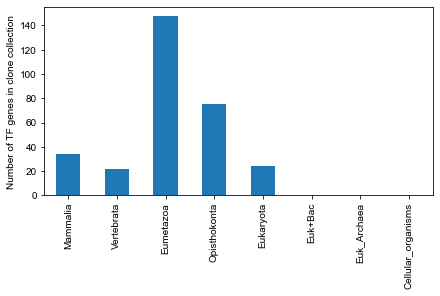

In [33]:
fig, ax = plt.subplots(1, 1)
age.value_counts().sort_index().plot.bar(ax=ax)
ax.set_ylabel('Number of TF genes in clone collection')
fig.savefig('../figures/gene-age_TFiso_bar.pdf', bbox_inches='tight')

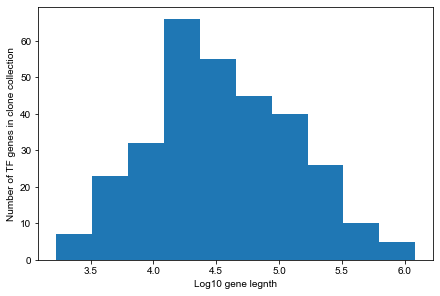

In [12]:
fig, ax = plt.subplots(1, 1)
gene_length.apply(np.log10).plot.hist(ax=ax)
ax.set_ylabel('Number of TF genes in clone collection')
ax.set_xlabel('Log10 gene legnth')
fig.savefig('../figures/gene-length_log10_TFiso_hist.pdf', bbox_inches='tight')

In [34]:
df['category'].value_counts()

paralogs               874
isoforms               447
non-paralog-control     15
Name: category, dtype: int64

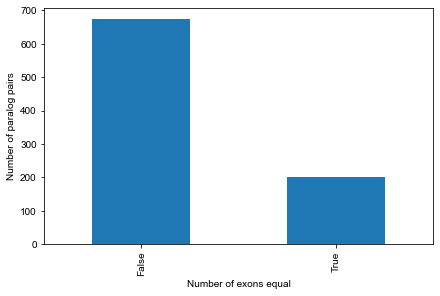

In [35]:
fig, ax = plt.subplots(1, 1)
df.loc[(df['category'] == 'paralogs'), 'is_n_exons_equal'].value_counts().plot.bar(ax=ax)
ax.set_xlabel('Number of exons equal')
ax.set_ylabel('Number of paralog pairs')
fig.savefig('../figures/n-exons-equal_paralog-pairs_bar.pdf', bbox_inches='tight')

In [27]:
# TMP - copy back to .py file
from plotting import binary_profile_matrix, strikethrough, isoform_display_name
from data_loading import paralog_pair_ppi_table

def y2h_ppi_per_paralog_pair_plot(tf_gene_a,
                                  tf_gene_b,
                                  data,
                                  ax=None,
                                  min_n_isoforms=1,
                                  min_n_partners=1):
    """

    TODO: gap between the two genes?
    
    Arguments:
        tf_gene_a {str} -- [description]
        tf_gene_b {str} -- [description]
        data {pandas.DataFrame} -- [description]
        ax {pandas.DataFrame} -- [description] (default: {None})
        min_n_isoforms {int} -- [description] (default: {1})
        min_n_partners {int} -- [description] (default: {1})
    
    """
    tf = paralog_pair_ppi_table(data, tf_gene_a, tf_gene_b)
    #tf['Y2H_result'] = tf['Y2H_result'].map({'1': True,
    #                               '0': False,
    #                               'AA': np.nan,
    #                               'NC': np.nan})
    tf['ad_clone_acc'] = tf['ad_clone_acc'].apply(isoform_display_name)
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PPI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        return
    binary_profile_matrix(tf, ax=ax, column_label_rotation=90)
    ax.set_yticklabels([strikethrough(name) if all_na else name
                        for name, all_na in tf.isnull().all(axis=1).iteritems()])

In [31]:
from data_loading import load_full_y2h_data_including_controls

y2h = load_full_y2h_data_including_controls()

<ipython-input-27-3635c2402c65>:48: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, all_na in tf.isnull().all(axis=1).iteritems()])


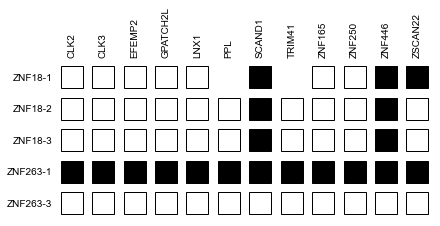

In [32]:
fig, ax = plt.subplots(1, 1)
gene_a = 'ZNF18'
gene_b = 'ZNF263'
y2h_ppi_per_paralog_pair_plot(gene_a, gene_b, y2h, ax=ax)

<ipython-input-14-297e712aa891>:48: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, all_na in tf.isnull().all(axis=1).iteritems()])


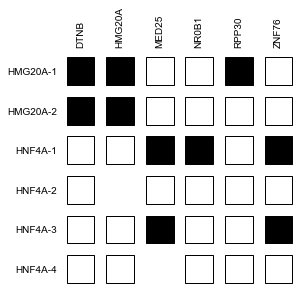

In [ ]:
# non-paralog control
fig, ax = plt.subplots(1, 1)
y2h_ppi_per_paralog_pair_plot('HMG20A', 'HNF4A', y2h, ax=ax)

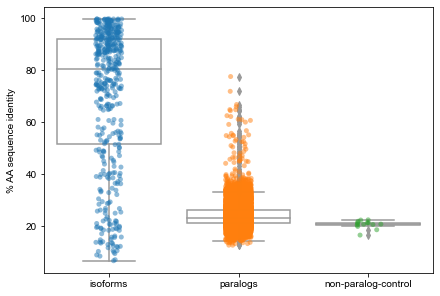

In [4]:
# sequence similarity
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.boxplot(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='white',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('% AA sequence identity')
fig.savefig('../figures/isoforms_vs_paralogs_all_pairs_aa_seq_id.pdf',
            bbox_inches='tight')

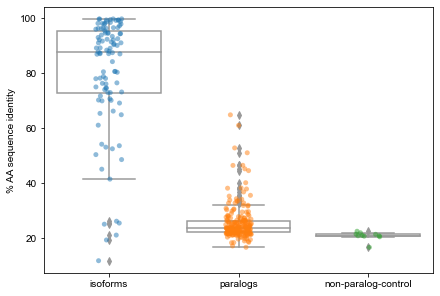

In [6]:
# sequence similarity
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df.loc[df['PPI_jaccard'].notnull(), :],
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.boxplot(data=df.loc[df['PPI_jaccard'].notnull(), :],
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='white',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('% AA sequence identity')
fig.savefig('../figures/isoforms_vs_paralogs_with_ppi_aa_seq_id.pdf',
            bbox_inches='tight')

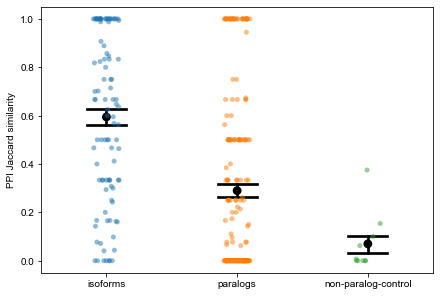

In [7]:
# cat plot with ppi jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df,
            x='category',
            y='PPI_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df,
            x='category',
            y='PPI_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_PPI_jaccard.pdf',
            bbox_inches='tight')

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


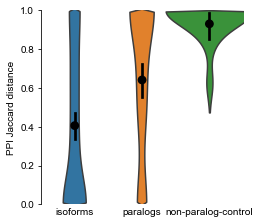

In [8]:
# TODO: add p-values
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.3,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PPI Jaccard distance')
fig.savefig('../figures/isoforms_vs_paralogs_PPI_jaccard_violin.pdf',
            bbox_inches='tight')

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


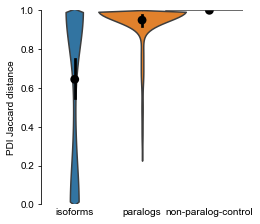

In [20]:
# TODO: change bandwidth of violin plot????
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.3,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PDI Jaccard distance')
fig.savefig('../figures/isoforms_vs_paralogs_PDI_jaccard_violin.pdf',
            bbox_inches='tight')

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


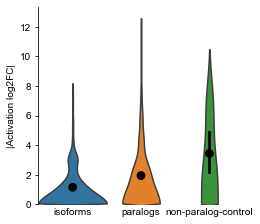

In [24]:
# HACK should just be using violoin plot but it's broken by the reflection
# HACK so just putting very high upper bound
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.,
            ub=9999999,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, None)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('|Activation log2FC|')
fig.savefig('../figures/isoforms_vs_paralogs_activation_violin.pdf',
            bbox_inches='tight')

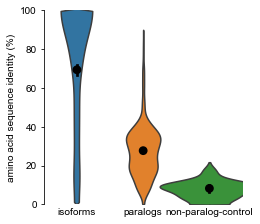

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.5,
            ub=100,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 100)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('amino acid sequence identity (%)')
fig.savefig('../figures/isoforms_vs_paralogs_seq_id_violin.pdf',
            bbox_inches='tight')

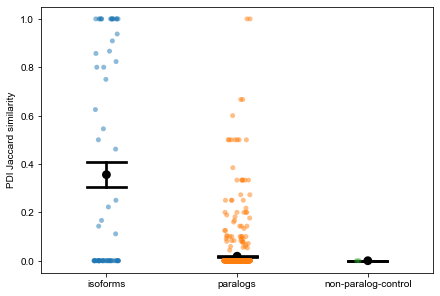

In [8]:
# PDI jaccard
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df,
            x='category',
            y='PDI_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.5,
            ax=ax)
sns.pointplot(data=df,
            x='category',
            y='PDI_jaccard',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_PDI_jaccard.pdf',
            bbox_inches='tight')

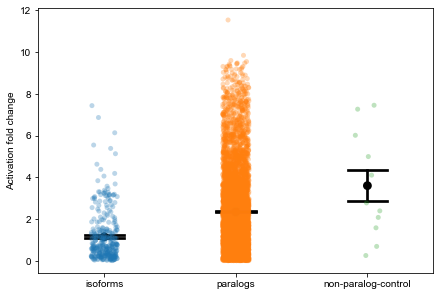

In [9]:
# activation change
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            alpha=0.3,
            ax=ax)
sns.pointplot(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            ci=68,
            capsize=0.3,
            linestyles='',
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Activation fold change')
fig.savefig('../figures/isoforms_vs_paralogs_activation.pdf',
            bbox_inches='tight')

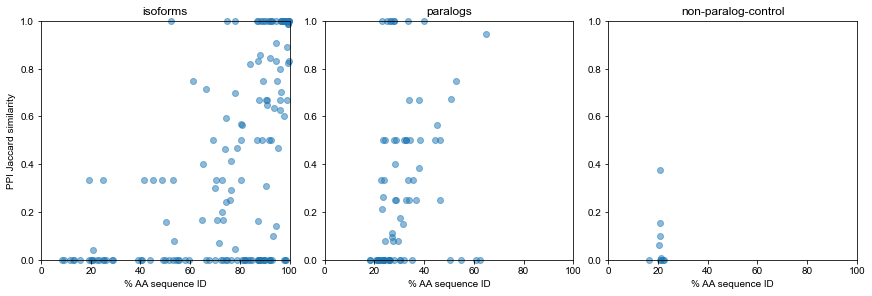

In [41]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat),
            ['aa_seq_pct_identity', 'PPI_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
axes[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PPI_jaccard_panels.pdf',
            bbox_inches='tight')

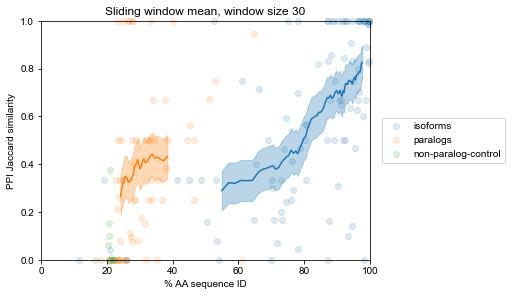

In [28]:
# add moving average
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=7, h=4)
window_size = 30
color = {'isoforms': 'C0',
         'paralogs': 'C1',
         'non-paralog-control': 'C2'}
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[
            (df['category'] == cat),
            ['aa_seq_pct_identity', 'PPI_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat,
               color=color[cat])
    avrg = (df.loc[ 
                   (df['category'] == cat)
                   & df['PPI_jaccard'].notnull(),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'PPI_jaccard']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], 
            avrg[:, 1],
            color=color[cat])
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    color=color[cat])

ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PPI Jaccard similarity')
ax.legend(loc='center left', bbox_to_anchor=[1.02, 0.5])
ax.set_title('Sliding window mean, window size 30')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PPI_jaccard_onefig.pdf',
            bbox_inches='tight')

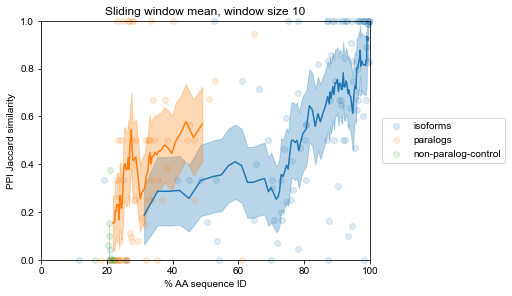

In [27]:
# add moving average
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=7, h=4)
window_size = 10
color = {'isoforms': 'C0',
         'paralogs': 'C1',
         'non-paralog-control': 'C2'}
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[
            (df['category'] == cat),
            ['aa_seq_pct_identity', 'PPI_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat,
               color=color[cat])
    avrg = (df.loc[ 
                   (df['category'] == cat)
                   & df['PPI_jaccard'].notnull(),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'PPI_jaccard']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], 
            avrg[:, 1],
            color=color[cat])
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    lw=0,
                    color=color[cat])

ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PPI Jaccard similarity')
ax.legend(loc='center left', bbox_to_anchor=[1.02, 0.5])
ax.set_title('Sliding window mean, window size 10')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PPI_jaccard_onefig_different-window.pdf',
            bbox_inches='tight')

In [39]:
# get examples
df.loc[(df['category'] == 'isoforms')
       & (df['aa_seq_pct_identity'] < 23),
       ['clone_acc_a', 'clone_acc_b', 'aa_seq_pct_identity', 'activation_abs_fold_change_log2']
       ].sort_values('activation_abs_fold_change_log2', ascending=False).head()

,clone_acc_a,clone_acc_b,aa_seq_pct_identity,activation_abs_fold_change_log2
1111,CREBZF|1/2|04B03,CREBZF|2/2|04C04,12.868633,4.377453
1257,ZNF473|1/2|10F12,ZNF473|2/2|01B08,8.840413,3.170526
1036,ZNF655|2/6|12G07,ZNF655|4/6|03C06,19.009901,2.547670
1287,ZNF264|1/4|12E08,ZNF264|4/4|05H03,10.207337,2.544065
1042,FOXP2|2/10|07B01,FOXP2|10/10|06A10,9.370629,2.235620


(0.0, 1.0)

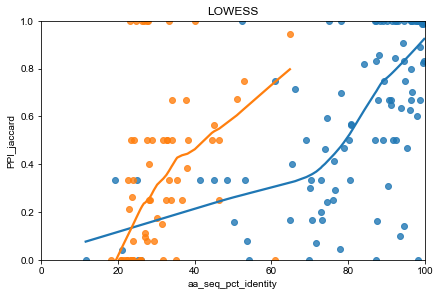

In [19]:
# trying lowess
# currently can't do confidence bands for lowess
fig, ax = plt.subplots(1, 1)
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='PPI_jaccard',
            lowess=True,
            ax=ax,
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='PPI_jaccard',
            lowess=True,
            ax=ax,
            )
ax.set_title('LOWESS')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

(0.0, 1.0)

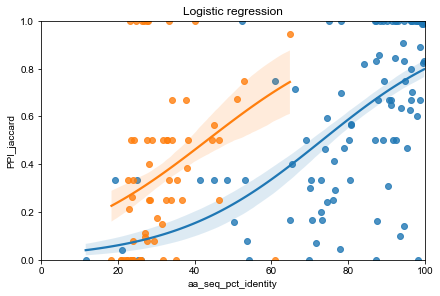

In [20]:
# Try logistic
fig, ax = plt.subplots(1, 1)
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='PPI_jaccard',
            logistic=True,
            ci=68,
            ax=ax
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='PPI_jaccard',
            logistic=True,
            ci=68,
            ax=ax
            )
ax.set_title('Logistic regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 65.267
Model:                      BetaModel   AIC:                            -124.5
Method:            Maximum Likelihood   BIC:                            -116.7
Date:                Tue, 14 Nov 2023                                         
Time:                        13:46:08                                         
No. Observations:                 100                                         
Df Residuals:                      97                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5267      0.528     -4.782      0.000      -3.562      -1.491
x1             0.0373      0.006      5.794      0.0

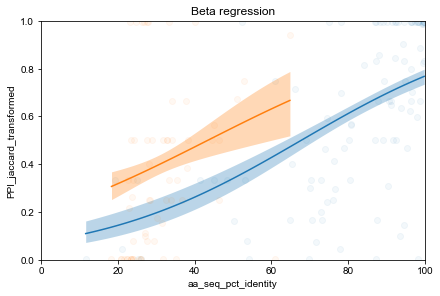

In [35]:
# beta regression
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

color = {'isoforms': 'C0', 'paralogs': 'C1'}

n = df['PPI_jaccard'].notnull().sum()
df['PPI_jaccard_transformed'] = ((df['PPI_jaccard'] * (n - 1) + 0.5)) / n
var = 'PPI_jaccard_transformed'
fig, ax = plt.subplots(1, 1)
for cat in ['isoforms', 'paralogs']:
    x, y = df.loc[(df['category'] == cat)
                  & df[var].notnull(),
                  ['aa_seq_pct_identity', var]].values.T
    ax.scatter(x=x, y=y, alpha=0.05, color=color[cat])
    x_with_const = sm.add_constant(x)
    beta_model = BetaModel(endog=y,
                           exog=x_with_const)
    result = beta_model.fit()
    print(result.summary())
    x_dummy = np.linspace(x.min(), x.max(), 100)
    x_dummy_with_const = sm.add_constant(x_dummy)
    predictions = result.predict(x_dummy_with_const)
    conf_int = result.get_prediction(x_dummy_with_const).conf_int(alpha=0.32)
    ax.plot(x_dummy, predictions, label='GLM Fit', color=color[cat])
    ax.fill_between(x=x_dummy, 
                    y1=conf_int[:, 0], 
                    y2=conf_int[:, 1], 
                    color=color[cat], 
                    alpha=0.3,
                    lw=0,
                    label='68% CI')



ax.set_title('Beta regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xlabel('aa_seq_pct_identity')
ax.set_ylabel(var)
fig.savefig('../figures/paralogs-vs-isoforms_PPI-jaccard_beta-regression.pdf',
            bbox_inches='tight')

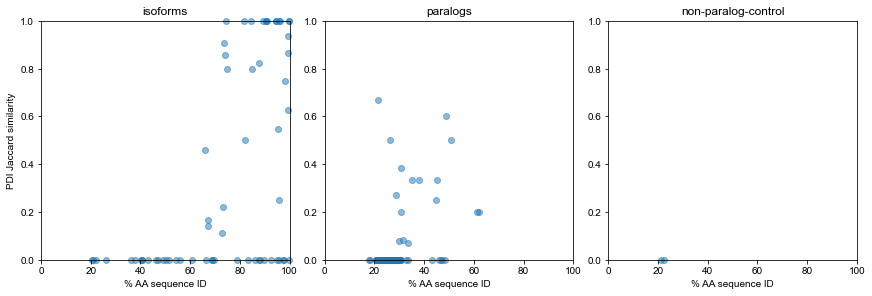

In [43]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat),
            ['aa_seq_pct_identity', 'PDI_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
axes[0].set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PDI_jaccard_panels.pdf',
            bbox_inches='tight')

In [44]:
df.loc[(df['category'] == 'isoforms') &
           (df['PDI_jaccard'].notnull())].shape

(64, 44)

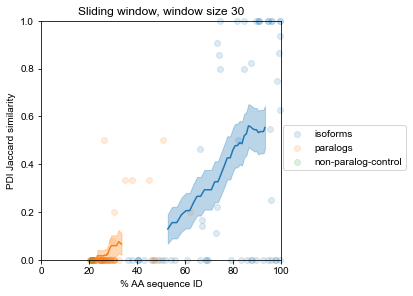

In [62]:
window_size = 30

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)

for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[(df['category'] == cat) &
           (df['PDI_jaccard'].notnull()),
            ['aa_seq_pct_identity', 'PDI_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat)
    avrg = (df.loc[(df['category'] == cat) &
           (df['PDI_jaccard'].notnull()),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'PDI_jaccard']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1])
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    color=color[cat])
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_title('Sliding window, window size 30')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PDI_jaccard_onefig.pdf',
            bbox_inches='tight')

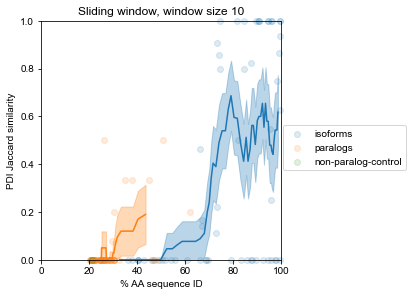

In [63]:
window_size = 10

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)

for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[(df['category'] == cat) &
           (df['PDI_jaccard'].notnull()),
            ['aa_seq_pct_identity', 'PDI_jaccard']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat)
    avrg = (df.loc[(df['category'] == cat) &
           (df['PDI_jaccard'].notnull()),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'PDI_jaccard']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1])
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    color=color[cat])
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_title('Sliding window, window size 10')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PDI_jaccard_onefig_window10.pdf',
            bbox_inches='tight')

47 20
0.9614468864468864 0.8680702014035347
29 69
0.09337668504335161
p= 0.0428


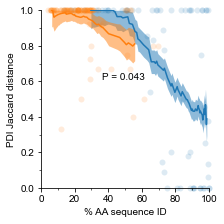

In [4]:
window_size = 40
n_min = 10


var = 'PDI_Jaccard_d'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

color = {'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'}

# calculate bootstrap uncertainty by number of data points
err = {}
all_vals = df[var].dropna().values
for n in range(n_min, 100):
    rnd_means = []
    for _i in range(1000):
        rnd_means.append(
            np.mean(np.random.choice(all_vals, size=n, replace=True))
            )
    mean = np.mean(rnd_means)
    err_up = np.quantile(rnd_means, q=0.84) - mean
    err_dn = mean - np.quantile(rnd_means, q=0.16)
    err[n] = max([err_up, err_dn])  # taking a conservative approach
             

# p-value using permutation test within a window
# use window where they overlap the most, as quantified by
# the max across all windows of the min of the two #pairs 
# (# paralog pairs and # isoform pairs) in each window
max_min_n = 0
for i in range(-window_size, 100):
    binned_rows = (df[var].notnull() 
                   & (df['aa_seq_pct_identity'] >= i)
                   & (df['aa_seq_pct_identity'] < i + window_size))
    min_n = min([
        (binned_rows & (df['category'] == 'isoforms')).sum(),
        (binned_rows & (df['category'] == 'paralogs')).sum()
    ])
    if min_n > max_min_n:
        bin_low = i
        bin_high = i + window_size
        max_min_n = min_n
overlap = df.loc[df['category'].isin(['isoforms', 'paralogs'])
                 & df[var].notnull()
                & (df['aa_seq_pct_identity'] >= bin_low)
                 & (df['aa_seq_pct_identity'] < bin_high),
                ['category', var]]
val_a = overlap.loc[overlap['category'] == 'isoforms', var].mean()
val_b = overlap.loc[overlap['category'] == 'paralogs', var].mean()
obs_val = val_a - val_b
all_vals = overlap[var].values
rnd_vals = []
n_a = (overlap['category'] == 'isoforms').sum()
np.random.seed(84349723)
for _i in range(20000):
    shuffled = np.random.choice(all_vals, size=len(all_vals), replace=False)
    rnd_vals.append(shuffled[:n_a].mean() - shuffled[n_a:].mean())
rnd_vals = np.array(rnd_vals)
p_val = ((rnd_vals >= obs_val).sum() / len(rnd_vals)) * 2
print(len(all_vals), n_a)
print(val_a, val_b)
print(bin_low, bin_high)
print(obs_val)
print('p=', p_val)


for cat in ['isoforms', 'paralogs']:
    xy = df.loc[(df['category'] == cat) &
           (df[var].notnull()),
            ['aa_seq_pct_identity', var]].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat,
               lw=0,
               )
    x, avrg, ci_dn, ci_up = [], [], [], []
    for i in range(-window_size, 100):
        subset = df.loc[(df['category'] == cat) 
                        & (df[var].notnull())
                        & (df['aa_seq_pct_identity'] >= i)
                        & (df['aa_seq_pct_identity'] < i + window_size),
                        ['aa_seq_pct_identity', var]]
        n = subset.shape[0]
        if n < n_min:
            continue
        x.append(subset['aa_seq_pct_identity'].mean())
        avrg.append(subset[var].mean())
        ci_dn.append(max(avrg[-1] - err[n], 0))
        ci_up.append(min(avrg[-1] + err[n], 1))

    ax.plot(x, avrg)
    ax.fill_between(x=x, 
                    y1=ci_dn, 
                    y2=ci_up,
                    alpha=0.5,
                    color=color[cat],
                    lw=0,
                    )
ax.text(s=f'P = {p_val:.3f}',
        x=bin_low + window_size / 2,
        y=0.65,
        ha='center',
        va='top',
        )

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_ylabel('PDI Jaccard distance')
#ax.set_title('Sliding window mean, window size 20%, minimum points 10')
#fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PDI_jaccard_fixed_window.pdf',
            bbox_inches='tight')

45 23
0.6606398489520082 0.5508320052962911
33 73
0.10980784365571716
p= 0.1672


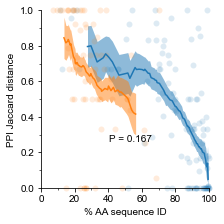

In [11]:
window_size = 40
n_min = 10
var = 'PPI_Jaccard_d'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

color = {'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'}

# calculate bootstrap uncertainty by number of data points
err = {}
all_vals = df[var].dropna().values
for n in range(n_min, 100):
    rnd_means = []
    for _i in range(1000):
        rnd_means.append(
            np.mean(np.random.choice(all_vals, size=n, replace=True))
            )
    mean = np.mean(rnd_means)
    err_up = np.quantile(rnd_means, q=0.84) - mean
    err_dn = mean - np.quantile(rnd_means, q=0.16)
    err[n] = max([err_up, err_dn])  # taking a conservative approach
             

# p-value using permutation test within a window
# use window where they overlap the most, as quantified by
# the max across all windows of the min of the two #pairs 
# (# paralog pairs and # isoform pairs) in each window
max_min_n = 0
for i in range(-window_size, 100):
    binned_rows = (df[var].notnull() 
                   & (df['aa_seq_pct_identity'] >= i)
                   & (df['aa_seq_pct_identity'] < i + window_size))
    min_n = min([
        (binned_rows & (df['category'] == 'isoforms')).sum(),
        (binned_rows & (df['category'] == 'paralogs')).sum()
    ])
    if min_n > max_min_n:
        bin_low = i
        bin_high = i + window_size
        max_min_n = min_n
overlap = df.loc[df['category'].isin(['isoforms', 'paralogs'])
                 & df[var].notnull()
                & (df['aa_seq_pct_identity'] >= bin_low)
                 & (df['aa_seq_pct_identity'] < bin_high),
                ['category', var]]
val_a = overlap.loc[overlap['category'] == 'isoforms', var].mean()
val_b = overlap.loc[overlap['category'] == 'paralogs', var].mean()
obs_val = val_a - val_b
all_vals = overlap[var].values
rnd_vals = []
n_a = (overlap['category'] == 'isoforms').sum()
np.random.seed(84349723)
for _i in range(20000):
    shuffled = np.random.choice(all_vals, size=len(all_vals), replace=False)
    rnd_vals.append(shuffled[:n_a].mean() - shuffled[n_a:].mean())
rnd_vals = np.array(rnd_vals)
p_val = ((rnd_vals >= obs_val).sum() / len(rnd_vals)) * 2
print(len(all_vals), n_a)
print(val_a, val_b)
print(bin_low, bin_high)
print(obs_val)
print('p=', p_val)


for cat in ['isoforms', 'paralogs']:
    xy = df.loc[(df['category'] == cat) &
           (df[var].notnull()),
            ['aa_seq_pct_identity', var]].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.15,
               label=cat,
               lw=0,
               )
    x, avrg, ci_dn, ci_up = [], [], [], []
    for i in range(-window_size, 100):
        subset = df.loc[(df['category'] == cat) 
                        & (df[var].notnull())
                        & (df['aa_seq_pct_identity'] >= i)
                        & (df['aa_seq_pct_identity'] < i + window_size),
                        ['aa_seq_pct_identity', var]]
        n = subset.shape[0]
        if n < n_min:
            continue
        x.append(subset['aa_seq_pct_identity'].mean())
        avrg.append(subset[var].mean())
        ci_dn.append(max(avrg[-1] - err[n], 0))
        ci_up.append(min(avrg[-1] + err[n], 1))

    ax.plot(x, avrg)
    ax.fill_between(x=x, 
                    y1=ci_dn, 
                    y2=ci_up,
                    alpha=0.5,
                    color=color[cat],
                    lw=0,
                    )
ax.text(s=f'P = {p_val:.3f}',
        x=bin_low + window_size / 2,
        y=0.3,
        ha='center',
        va='top',
        )

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_ylabel('PPI Jaccard distance')
#ax.set_title('Sliding window mean, window size 20%, minimum points 10')
#fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_PPI_jaccard_fixed_window.pdf',
            bbox_inches='tight')

In [145]:
df.head()

,gene_symbol_a,gene_symbol_b,is_tested_in_Y2H,aa_seq_pct_identity,clone_acc_a,clone_acc_b,category,family_a,family_b,is_MANE_select_isoform_cloned_a,is_MANE_select_isoform_cloned_b,is_MANE_select_isoform_cloned_both,n_positive_PPI_a,n_positive_PPI_b,n_PPI_successfully_tested_in_a_and_b,n_positive_PPI_a_filtered,n_positive_PPI_b_filtered,n_shared_PPI,n_PPI_diff,PPI_jaccard,n_positive_PDI_a,n_positive_PDI_b,n_PDI_successfully_tested_in_a_and_b,n_positive_PDI_a_filtered,n_positive_PDI_b_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_a_abs_activation_gte_2fold,at_least_one_isoform_in_gene_b_abs_activation_gte_2fold,activation_a,activation_b,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d
0,ZKSCAN3,ZNF263,False,32.861806,ZKSCAN3|2/2|07C05,ZNF263|1/3|11C01,paralogs,C2H2 ZF,C2H2 ZF,False,True,False,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,True,1.571580,4.407654,2.836075,NaN,NaN
1,ZNF263,ZSCAN21,False,31.963470,ZNF263|1/3|11C01,ZSCAN21|1/3|10H09,paralogs,C2H2 ZF,C2H2 ZF,True,True,True,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,4.407654,1.410804,2.996850,NaN,NaN
2,ZNF24,ZNF263,False,27.703524,ZNF24|1/2|01B07,ZNF263|1/3|11C01,paralogs,C2H2 ZF,C2H2 ZF,True,True,True,2.0,12.0,4.0,2.0,4.0,2.0,2.0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,True,0.641802,4.407654,3.765852,0.5,NaN
3,ZNF263,ZNF75A,False,23.455233,ZNF263|1/3|11C01,ZNF75A|1/2|11B06,paralogs,C2H2 ZF,C2H2 ZF,True,NaN,False,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,False,4.407654,-0.763338,5.170992,NaN,NaN
4,ZNF263,ZSCAN25,True,32.792208,ZNF263|1/3|11C01,ZSCAN25|1/4|04A06,paralogs,C2H2 ZF,C2H2 ZF,True,True,True,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,4.407654,1.294304,3.113350,NaN,NaN


In [35]:
# TMP TEST
df.loc[(df['activation_a'].abs() < 1) &
       (df['activation_b'].abs() < 1), 
       'activation_abs_fold_change_log2'] = np.nan

<ipython-input-6-0837b603763c>:39: RuntimeWarning: divide by zero encountered in double_scalars
  sum_inv_sq = 1 / np.sqrt(n_a) + 1 / np.sqrt(n_b)


178 90
1.4648255435989885 1.1861360242021168
37 77
0.2786895193968717
p= 1.8778


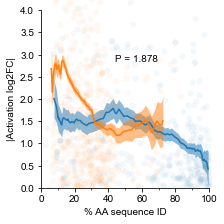

In [6]:
# TODO
# add in other non-overlapping windows
window_size = 40
n_min = 10
var = 'activation_abs_fold_change_log2'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

color = {'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'}

# calculate bootstrap uncertainty by number of data points
err = {}
all_vals = df[var].dropna().values
for n in range(n_min, 1000):
    rnd_means = []
    for _i in range(1000):
        rnd_means.append(
            np.mean(np.random.choice(all_vals, size=n, replace=True))
            )
    mean = np.mean(rnd_means)
    err_up = np.quantile(rnd_means, q=0.84) - mean
    err_dn = mean - np.quantile(rnd_means, q=0.16)
    err[n] = max([err_up, err_dn])  # taking a conservative approach
             
# p-value using permutation test within a window
# use window where they overlap the most, as quantified by
# the max across all windows of the min of the two #pairs 
# (# paralog pairs and # isoform pairs) in each window
max_min_n = 0
min_sum_inv_sq = 9999999
for i in range(-window_size, 100):
    binned_rows = (df[var].notnull() 
                   & (df['aa_seq_pct_identity'] >= i)
                   & (df['aa_seq_pct_identity'] < i + window_size))
    n_a = (binned_rows & (df['category'] == 'isoforms')).sum()
    n_b = (binned_rows & (df['category'] == 'paralogs')).sum()
    min_n = min([n_a, n_b])
    sum_inv_sq = 1 / np.sqrt(n_a) + 1 / np.sqrt(n_b)
    if min_n > max_min_n:
    #if sum_inv_sq < min_sum_inv_sq:
        bin_low = i
        bin_high = i + window_size
        max_min_n = min_n
        #min_sum_inv_sq = sum_inv_sq
overlap = df.loc[df['category'].isin(['isoforms', 'paralogs'])
                 & df[var].notnull()
                & (df['aa_seq_pct_identity'] >= bin_low)
                 & (df['aa_seq_pct_identity'] < bin_high),
                ['category', var]]
val_a = overlap.loc[overlap['category'] == 'isoforms', var].mean()
val_b = overlap.loc[overlap['category'] == 'paralogs', var].mean()
obs_val = val_a - val_b
all_vals = overlap[var].values
rnd_vals = []
n_a = (overlap['category'] == 'isoforms').sum()
np.random.seed(84349723)
for _i in range(20000):
    shuffled = np.random.choice(all_vals, size=len(all_vals), replace=False)
    rnd_vals.append(shuffled[:n_a].mean() - shuffled[n_a:].mean())
rnd_vals = np.array(rnd_vals)
p_val = ((rnd_vals <= obs_val).sum() / len(rnd_vals)) * 2
print(len(all_vals), n_a)
print(val_a, val_b)
print(bin_low, bin_high)
print(obs_val)
print('p=', p_val)


for cat in ['isoforms', 'paralogs']:
    xy = df.loc[(df['category'] == cat) &
           (df[var].notnull()),
            ['aa_seq_pct_identity', var]].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.05,
               label=cat,
               lw=0,
               )
    x, avrg, ci_dn, ci_up = [], [], [], []
    for i in range(-window_size, 100):
        subset = df.loc[(df['category'] == cat) 
                        & (df[var].notnull())
                        & (df['aa_seq_pct_identity'] >= i)
                        & (df['aa_seq_pct_identity'] < i + window_size),
                        ['aa_seq_pct_identity', var]]
        n = subset.shape[0]
        if n < n_min:
            continue
        x.append(subset['aa_seq_pct_identity'].mean())
        avrg.append(subset[var].mean())
        ci_dn.append(max(avrg[-1] - err[n], 0))
        ci_up.append(avrg[-1] + err[n])

    ax.plot(x, avrg)
    ax.fill_between(x=x, 
                    y1=ci_dn, 
                    y2=ci_up,
                    alpha=0.5,
                    color=color[cat],
                    lw=0,
                    )
ax.text(s=f'P = {p_val:.3f}',
        x=bin_low + window_size / 2,
        y=3,
        ha='center',
        va='top',
        )

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
ax.set_ylim(0, 4)
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
#ax.set_yticks(np.linspace(0, 1, 6))
#ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_ylabel('|Activation log2FC|')
#ax.set_title('Sliding window mean, window size 20%, minimum points 10')
#fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_abslog2fc_fixed_window.pdf',
            bbox_inches='tight')

In [15]:
# inspecting the low seq ID isoforms
df.loc[(df['category'] == 'isoforms')
       & df['activation_abs_fold_change_log2'].notnull()].sort_values('aa_seq_pct_identity').head(10)

,gene_symbol_a,gene_symbol_b,is_tested_in_Y2H,aa_seq_pct_identity,clone_acc_a,clone_acc_b,category,family_a,family_b,is_MANE_select_isoform_cloned_a,is_MANE_select_isoform_cloned_b,is_MANE_select_isoform_cloned_both,n_positive_PPI_a,n_positive_PPI_b,n_PPI_successfully_tested_in_a_and_b,n_positive_PPI_a_filtered,n_positive_PPI_b_filtered,n_shared_PPI,n_PPI_diff,PPI_jaccard,n_positive_PDI_a,n_positive_PDI_b,n_PDI_successfully_tested_in_a_and_b,n_positive_PDI_a_filtered,n_positive_PDI_b_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_a_abs_activation_gte_2fold,at_least_one_isoform_in_gene_b_abs_activation_gte_2fold,activation_a,activation_b,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d
1201,ZFP1,ZFP1,NaN,2.139037,ZFP1|2/4|04D02,ZFP1|4/4|04C01,isoforms,C2H2 ZF,C2H2 ZF,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,True,-0.617791,0.339418,0.957208,NaN,NaN
1299,ZNF180,ZNF180,NaN,3.462604,ZNF180|2/4|02G08,ZNF180|1/4|10E12,isoforms,C2H2 ZF,C2H2 ZF,False,False,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.762538,-0.593331,1.355869,NaN,NaN
1111,CREBZF,CREBZF,NaN,4.485488,CREBZF|1/2|04B03,CREBZF|2/2|04C04,isoforms,bZIP,bZIP,True,True,True,3.0,0.0,3.0,3.0,0.0,0.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,3.414345,-0.963108,4.377453,NaN,NaN
1265,ZNF544,ZNF544,NaN,7.777778,ZNF544|1/7|10A12,ZNF544|7/7|02H04,isoforms,C2H2 ZF,C2H2 ZF,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,-1.501519,1.527333,3.028852,NaN,NaN
1042,FOXP2,FOXP2,NaN,7.960894,FOXP2|2/10|07B01,FOXP2|10/10|06A10,isoforms,Forkhead,Forkhead,True,True,True,12.0,0.0,12.0,12.0,0.0,0.0,12.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,3.640735,5.876355,2.235620,NaN,NaN
1257,ZNF473,ZNF473,NaN,8.610792,ZNF473|1/2|10F12,ZNF473|2/2|01B08,isoforms,C2H2 ZF,C2H2 ZF,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,7.223517,10.394043,3.170526,NaN,NaN
1209,ZNF23,ZNF23,NaN,8.755760,ZNF23|2/3|12F07,ZNF23|3/3|06C03,isoforms,C2H2 ZF,C2H2 ZF,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,-0.411029,1.039209,1.450238,NaN,NaN
1287,ZNF264,ZNF264,NaN,8.888889,ZNF264|1/4|12E08,ZNF264|4/4|05H03,isoforms,C2H2 ZF,C2H2 ZF,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,1.847797,-0.696268,2.544065,NaN,NaN
1286,ZNF264,ZNF264,NaN,8.950617,ZNF264|1/4|12E08,ZNF264|3/4|05D04,isoforms,C2H2 ZF,C2H2 ZF,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,True,1.847797,1.116631,0.731166,NaN,NaN
1200,ZFP1,ZFP1,NaN,9.090909,ZFP1|2/4|04D02,ZFP1|3/4|03B11,isoforms,C2H2 ZF,C2H2 ZF,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,True,-0.617791,0.077712,0.695503,NaN,NaN


(0.0, 1.0)

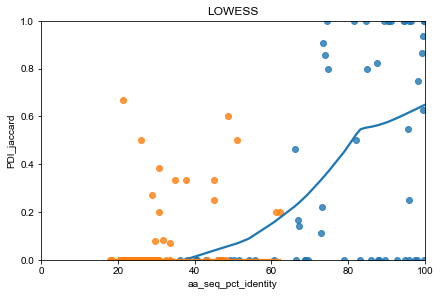

In [52]:
# trying lowess
# currently can't do confidence bands for lowess
fig, ax = plt.subplots(1, 1)
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='PDI_jaccard',
            lowess=True,
            ax=ax,
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='PDI_jaccard',
            lowess=True,
            ax=ax,
            )
ax.set_title('LOWESS')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

(0.0, 1.0)

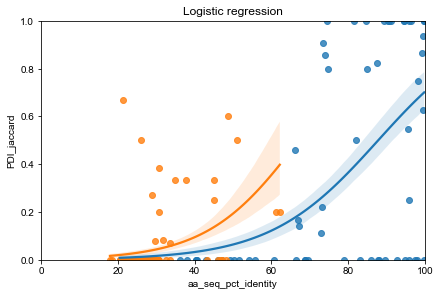

In [53]:
# Try logistic
fig, ax = plt.subplots(1, 1)
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='PDI_jaccard',
            logistic=True,
            ci=68,
            ax=ax
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='PDI_jaccard',
            logistic=True,
            ci=68,
            ax=ax
            )
ax.set_title('Logistic regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 109.56
Model:                      BetaModel   AIC:                            -213.1
Method:            Maximum Likelihood   BIC:                            -206.6
Date:                Tue, 14 Nov 2023                                         
Time:                        15:27:06                                         
No. Observations:                  64                                         
Df Residuals:                      61                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2148      0.693     -3.194      0.001      -3.574      -0.856
x1             0.0249      0.008      2.959      0.0

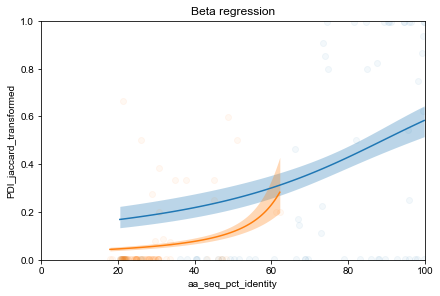

In [47]:
# beta regression
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

color = {'isoforms': 'C0', 'paralogs': 'C1'}

n = df['PDI_jaccard'].notnull().sum()
df['PDI_jaccard_transformed'] = ((df['PDI_jaccard'] * (n - 1) + 0.5)) / n
var = 'PDI_jaccard_transformed'
fig, ax = plt.subplots(1, 1)
for cat in ['isoforms', 'paralogs']:
    x, y = df.loc[(df['category'] == cat)
                  & df[var].notnull(),
                  ['aa_seq_pct_identity', var]].values.T
    ax.scatter(x=x, y=y, alpha=0.05, color=color[cat])
    x_with_const = sm.add_constant(x)
    # try links
    # logit, probit, complementary log-log, cauchy
    beta_model = BetaModel(endog=y,
                           exog=x_with_const,
                           link=sm.genmod.families.links.Cauchy(),
                           link_precision=sm.genmod.families.links.Identity())
    result = beta_model.fit()
    print(result.summary())
    x_dummy = np.linspace(x.min(), x.max(), 100)
    x_dummy_with_const = sm.add_constant(x_dummy)
    predictions = result.predict(x_dummy_with_const)
    conf_int = result.get_prediction(x_dummy_with_const).conf_int(alpha=0.32)
    ax.plot(x_dummy, predictions, label='GLM Fit', color=color[cat])
    ax.fill_between(x=x_dummy, 
                    y1=conf_int[:, 0], 
                    y2=conf_int[:, 1], 
                    color=color[cat], 
                    alpha=0.3,
                    lw=0,
                    label='68% CI')



ax.set_title('Beta regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xlabel('aa_seq_pct_identity')
ax.set_ylabel(var)
fig.savefig('../figures/paralogs-vs-isoforms_PDI-jaccard_beta-regression.pdf',
            bbox_inches='tight')


# default link
# AIC:                            -212.7
# BIC:                            -206.2
# AIC:                            -528.1
# BIC:                            -520.3

# loglog
# AIC:                            -212.2
# BIC:                            -205.8
# AIC:                            -527.7
# BIC:                            -519.9

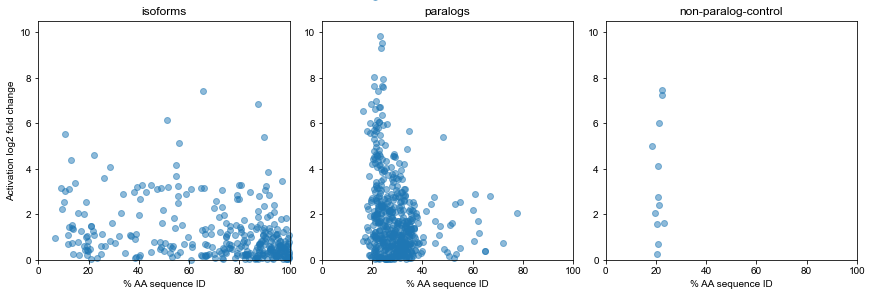

In [47]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

for cat, ax in zip(['isoforms', 'paralogs', 'non-paralog-control'], axes):
    xy = df.loc[(df['category'] == cat) &
           (df['activation_abs_fold_change_log2'].notnull()),
            ['aa_seq_pct_identity', 'activation_abs_fold_change_log2']].values
    ax.scatter(xy[:, 0], xy[:, 1], clip_on=False, alpha=0.5)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 10.5)
    ax.set_title(cat)
axes[0].set_ylabel('Activation log2 fold change')
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_panels.pdf',
            bbox_inches='tight')

<ipython-input-59-c5f462a832c0>:22: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
<ipython-input-59-c5f462a832c0>:22: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)


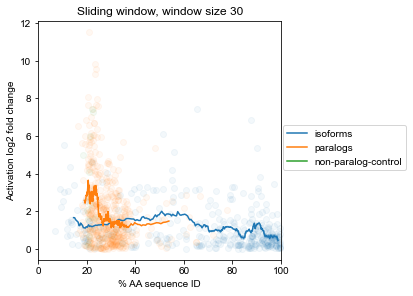

In [59]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
window_size = 30
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[(df['category'] == cat) &
           (df['activation_abs_fold_change_log2'].notnull()),
            ['aa_seq_pct_identity', 'activation_abs_fold_change_log2']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.05,
               )
    avrg = (df.loc[(df['category'] == cat) &
           (df['activation_abs_fold_change_log2'].notnull()),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'activation_abs_fold_change_log2']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1],
            label=cat)
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    color=color[cat])
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
#ax.set_ylim(0, 10.5)
ax.set_ylabel('Activation log2 fold change')
ax.set_title('Sliding window, window size 30')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_onefig.pdf',
            bbox_inches='tight')

<ipython-input-60-69f5fc13e98a>:22: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
<ipython-input-60-69f5fc13e98a>:22: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
<ipython-input-60-69f5fc13e98a>:22: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)


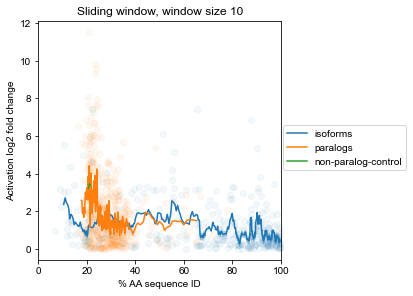

In [60]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
window_size = 10
for cat in ['isoforms', 'paralogs', 'non-paralog-control']:
    xy = df.loc[(df['category'] == cat) &
           (df['activation_abs_fold_change_log2'].notnull()),
            ['aa_seq_pct_identity', 'activation_abs_fold_change_log2']].values
    ax.scatter(xy[:, 0], 
               xy[:, 1],
               clip_on=False, 
               alpha=0.05,
               )
    avrg = (df.loc[(df['category'] == cat) &
           (df['activation_abs_fold_change_log2'].notnull()),
            :]
         .sort_values('aa_seq_pct_identity')
         [['aa_seq_pct_identity', 'activation_abs_fold_change_log2']]
         .rolling(window_size, center=True)
         .mean()).dropna().values
    ax.plot(avrg[:,0], avrg[:, 1],
            label=cat)
    std_err = np.sqrt((avrg[:, 1] * (1 - avrg[:, 1])) / window_size)
    ax.fill_between(x=avrg[:,0], 
                    y1=avrg[:, 1] - std_err, 
                    y2=avrg[:, 1] + std_err,
                    alpha=0.3,
                    color=color[cat])
ax.set_xlabel('% AA sequence ID')
ax.set_xlim(0, 100)
#ax.set_ylim(0, 10.5)
ax.set_ylabel('Activation log2 fold change')
ax.set_title('Sliding window, window size 10')
fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
fig.savefig('../figures/isoforms_vs_paralogs_aa_id_vs_activation_onefig.pdf',
            bbox_inches='tight')

(0.0, 10.01950845621534)

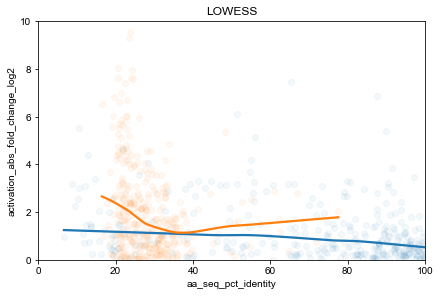

In [42]:
# trying lowess
# currently can't do confidence bands for lowess
fig, ax = plt.subplots(1, 1)
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='activation_abs_fold_change_log2',
            lowess=True,
                        scatter_kws={'alpha': 0.05},
            ax=ax,
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='activation_abs_fold_change_log2',
            lowess=True,
                        scatter_kws={'alpha': 0.05},
            ax=ax,
            )
ax.set_title('LOWESS')
ax.set_xlim(0, 100)
ax.set_ylim(0, None)

(0.0, 1.0499582148657294)

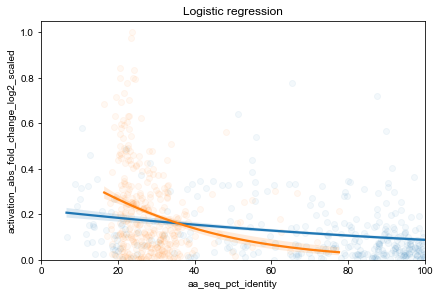

In [48]:
# regression
fig, ax = plt.subplots(1, 1)
df['activation_abs_fold_change_log2_scaled'] = (df['activation_abs_fold_change_log2']
                                                / 
                                                df['activation_abs_fold_change_log2'].max())
sns.regplot(data=df.loc[df['category'] == 'isoforms'],
            x='aa_seq_pct_identity',
            y='activation_abs_fold_change_log2_scaled',
            logistic=True,
            ci=68,
            scatter_kws={'alpha': 0.05},
            ax=ax
            )
sns.regplot(data=df.loc[df['category'] == 'paralogs'],
            x='aa_seq_pct_identity',
            y='activation_abs_fold_change_log2_scaled',
            logistic=True,
            ci=68,
            scatter_kws={'alpha': 0.05},
            ax=ax
            )
ax.set_title('Logistic regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, None)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  327
Model:                            GLM   Df Residuals:                      325
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                          1.0730
Method:                          IRLS   Log-Likelihood:                -362.16
Date:                Tue, 14 Nov 2023   Deviance:                       343.48
Time:                        12:20:53   Pearson chi2:                     349.
No. Iterations:                    13   Pseudo R-squ. (CS):            0.06883
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8245      0.157      5.257      0.0

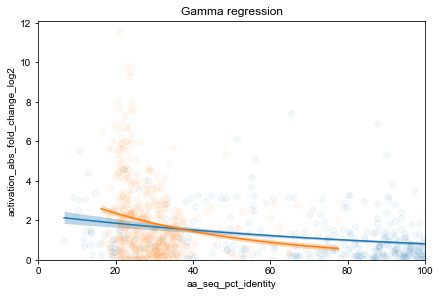

In [33]:
# GAMMA regression
import statsmodels.api as sm

color = {'isoforms': 'C0', 'paralogs': 'C1'}

var = 'activation_abs_fold_change_log2'
fig, ax = plt.subplots(1, 1)
for cat in ['isoforms', 'paralogs']:
    x, y = df.loc[(df['category'] == cat)
                  & df[var].notnull(),
                  ['aa_seq_pct_identity', var]].values.T
    ax.scatter(x=x, y=y, alpha=0.05, color=color[cat])
    x_with_const = sm.add_constant(x)
    gamma_model = sm.GLM(endog=y,
                         exog=x_with_const,
                         family=sm.families.Gamma(link=sm.genmod.families.links.Log()))
    result = gamma_model.fit()
    print(result.summary())
    # TODO: don't need for every data point?
    x_dummy = np.linspace(x.min(), x.max(), 100)
    x_dummy_with_const = sm.add_constant(x_dummy)
    predictions = result.predict(x_dummy_with_const)
    conf_int = result.get_prediction(x_dummy_with_const).conf_int(alpha=0.32)
    ax.plot(x_dummy, predictions, label='GLM Fit', color=color[cat])
    ax.fill_between(x=x_dummy, 
                    y1=conf_int[:, 0], 
                    y2=conf_int[:, 1], 
                    color=color[cat], 
                    alpha=0.3,
                    lw=0,
                    label='68% CI')



ax.set_title('Gamma regression')
ax.set_xlim(0, 100)
ax.set_ylim(0, None)
ax.set_xlabel('aa_seq_pct_identity')
ax.set_ylabel('activation_abs_fold_change_log2')
fig.savefig('../figures/paralogs-vs-isoforms_activation_gamma-regression.pdf',
            bbox_inches='tight')

<AxesSubplot: ylabel='Frequency'>

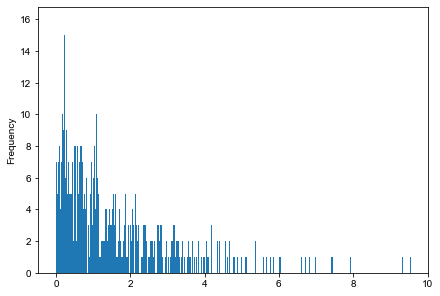

In [67]:
# GAMMA or lognormal?
df['activation_abs_fold_change_log2'].plot.hist(bins=500)

In [49]:
df.loc[df['category'] == 'paralogs', 'PPI_jaccard'].notnull().sum()

75

In [50]:
df.loc[df['category'] == 'paralogs', 'PDI_jaccard'].notnull().sum()

99

In [51]:
((df['category'] == 'paralogs')).sum()

874

In [52]:
((df['category'] == 'paralogs')
& df['PPI_jaccard'].notnull()
& df['PDI_jaccard'].notnull()).sum()

10

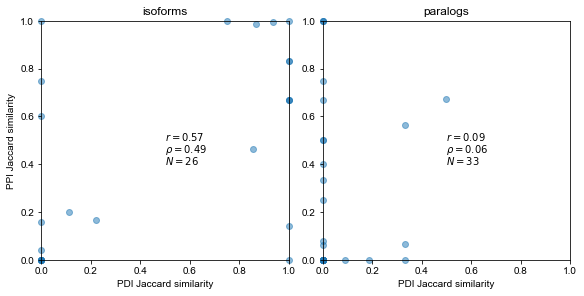

In [6]:
# is the PPI requirment to have non-zero consistent with PDI def?
# rotate 45%
# different from scatter???
# p-values

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xy = df.loc[(df['category'] == cat) &
                 df['PPI_jaccard'].notnull() &
                 df['PDI_jaccard'].notnull(),
            ['PDI_jaccard', 'PPI_jaccard']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('PDI Jaccard similarity')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(cat)
    ax.text(0.5, 0.5, r'$r = {:.2f}$'.format(stats.pearsonr(xy[:, 0], xy[:, 1])[0]))
    ax.text(0.5, 0.45, r'$\rho = {:.2f}$'.format(stats.spearmanr(xy[:, 0], xy[:, 1])[0]))
    ax.text(0.5, 0.4, r'$N = {:}$'.format(xy.shape[0]))
axes[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms_vs_paralogs_PDI_vs_PPI_Jaccard_panels.pdf',
            bbox_inches='tight')

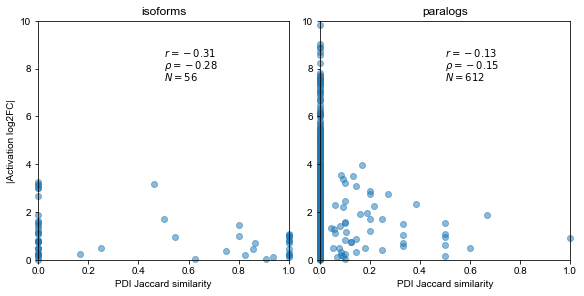

In [34]:
# n
# rotate 45%
# different from scatter???
# p-values

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

for cat, ax in zip(['isoforms', 'paralogs'], axes):
    xy = df.loc[(df['category'] == cat) &
                 df['activation_abs_fold_change_log2'].notnull() &
                 df['PDI_jaccard'].notnull(),
            ['PDI_jaccard', 'activation_abs_fold_change_log2']].values
    ax.scatter(xy[:, 0], xy[:, 1],
               clip_on=False, alpha=0.5)
    ax.set_xlabel('PDI Jaccard similarity')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    ax.set_title(cat)
    ax.text(0.5, 8.5, r'$r = {:.2f}$'.format(stats.pearsonr(xy[:, 0], xy[:, 1])[0]))
    ax.text(0.5, 8, r'$\rho = {:.2f}$'.format(stats.spearmanr(xy[:, 0], xy[:, 1])[0]))
    ax.text(0.5, 7.5, r'$N = {:}$'.format(xy.shape[0]))
axes[0].set_ylabel('|Activation log2FC|')
fig.savefig('../figures/isoforms_vs_paralogs_activation_vs_PDI_jaccard_panels.pdf',
            bbox_inches='tight')

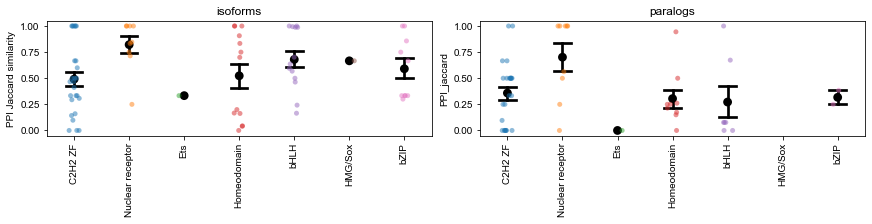

In [65]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='PPI_jaccard',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='PPI_jaccard',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('PPI Jaccard similarity')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_PPI-Jaccard.pdf',
            bbox_inches='tight')

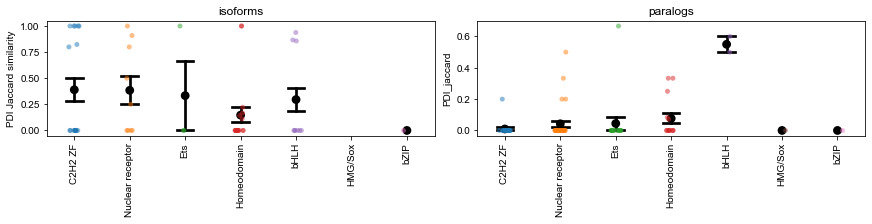

In [66]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[
                            (df['PDI_jaccard'].notnull()) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='PDI_jaccard',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[
                            (df['PDI_jaccard'].notnull()) &
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='PDI_jaccard',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('PDI Jaccard similarity')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_PDI-Jaccard.pdf',
            bbox_inches='tight')

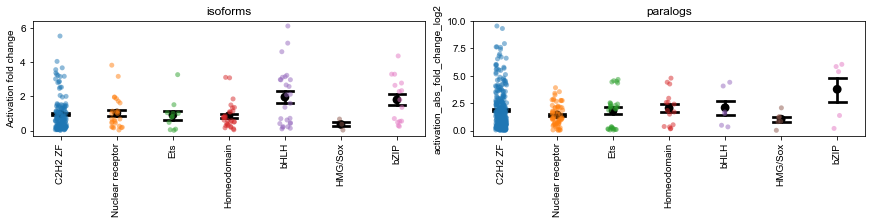

In [68]:
fam_to_plot = df['family'].value_counts().index[:7]

# cat plot with ppi jaccard
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=12, h=3)
for cat, ax in zip(['isoforms', 'paralogs'], axs):
    sns.stripplot(data=df.loc[
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='activation_abs_fold_change_log2',
                order=fam_to_plot,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=df.loc[
                            (df['category'] == cat) &
                            df['family'].isin(fam_to_plot), :],
                x='family',
                y='activation_abs_fold_change_log2',
                order=fam_to_plot,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    ax.set_title(cat)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
axs[0].set_ylabel('Activation fold change')
fig.savefig('../figures/isoforms-vs-paralogs_by-family_activation-abs-foldchange.pdf',
            bbox_inches='tight')

MannwhitneyuResult(statistic=301.0, pvalue=0.2519579858019805)
MannwhitneyuResult(statistic=1145.0, pvalue=0.3473857812020389)
MannwhitneyuResult(statistic=19017.0, pvalue=0.09081960342514799)


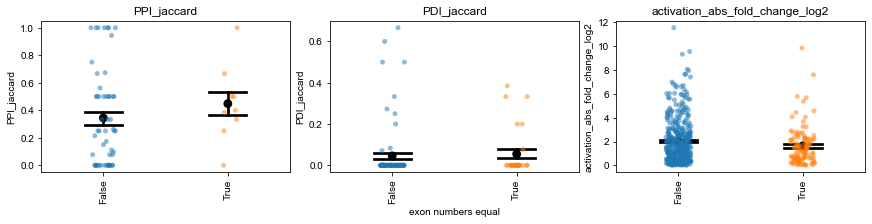

In [71]:
# TODO out of order
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(w=12, h=3)
for var, ax in zip(['PPI_jaccard', 'PDI_jaccard', 'activation_abs_fold_change_log2'], axs):
    data = df.loc[
                  (df['category'] == 'paralogs'), :]
    sns.stripplot(data=data,
                x='is_n_exons_equal',
                y=var,
                alpha=0.5,
                ax=ax)
    sns.pointplot(data=data,
                x='is_n_exons_equal',
                y=var,
                color='black',
                ci=68,
                capsize=0.3,
                linestyles='',
                ax=ax)
    print(stats.mannwhitneyu(data.loc[data['is_n_exons_equal'] & data[var].notnull(), var].values,
        data.loc[~data['is_n_exons_equal'] & data[var].notnull(), var].values))
    ax.set_title(var)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel('')
#axs[0].set_ylabel('Activation fold change')
axs[1].set_xlabel('exon numbers equal')
fig.savefig('../figures/paralogs_by-exon-n-equal_assaydiffs.pdf',
            bbox_inches='tight')

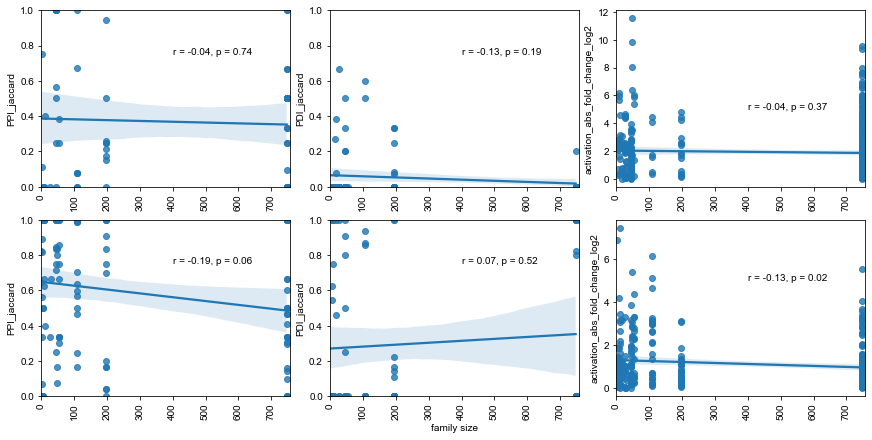

In [73]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['PPI_jaccard', 'PDI_jaccard', 'activation_abs_fold_change_log2'], ax_row):
        data = df.loc[
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='family_size',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        ax.set_xlim(0, df['family_size'].max() + 10)
        r, p = stats.pearsonr(data.loc[data['family_size'].notnull() & data[var].notnull(), 'family_size'].values,
                              data.loc[data['family_size'].notnull() & data[var].notnull(), var].values)
        ax.text(s='r = {:.2f}, p = {:.2f}'.format(r, p),
                x=400, y=5 if var == 'activation_abs_fold_change_log2' else 0.75)
#axs[0].set_ylabel('Activation fold change')
axs[1, 1].set_xlabel('family size')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-family-size_assaydiffs.pdf',
            bbox_inches='tight')

In [74]:
# TODO: move
df['gene_age_younger'] = pd.Series(pd.Categorical(df['gene_age_younger'].values,
                                                  categories=df['gene_age_a'].cat.categories,
                                                  ordered=True)).values

In [75]:
df['gene_age_younger_code'] = df['gene_age_younger'].cat.codes
df.loc[df['gene_age_younger'].isnull(), 'gene_age_younger_code'] = np.nan

In [76]:
df['gene_age_younger'].cat.categories.values

array(['Mammalia', 'Vertebrata', 'Eumetazoa', 'Opisthokonta', 'Eukaryota',
       'Euk+Bac', 'Euk_Archaea', 'Cellular_organisms'], dtype=object)

<ipython-input-77-6333985b9b5a>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(age_cats)


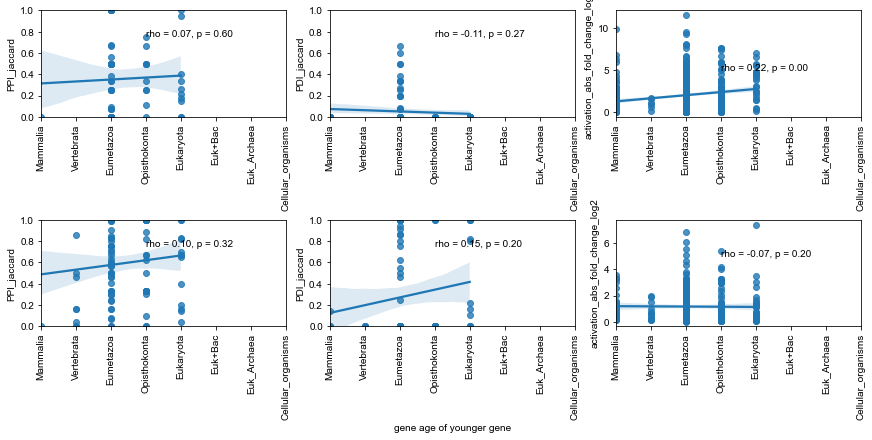

In [77]:
# TODO: map gene age to MYA
age_cats = df['gene_age_younger'].cat.categories.values
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['PPI_jaccard', 'PDI_jaccard', 'activation_abs_fold_change_log2'], ax_row):
        data = df.loc[
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='gene_age_younger_code',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        r, p = stats.spearmanr(data.loc[data['gene_age_younger_code'].notnull() & data[var].notnull(), 'gene_age_younger_code'].values,
                               data.loc[data['gene_age_younger_code'].notnull() & data[var].notnull(), var].values)
        ax.text(s='rho = {:.2f}, p = {:.2f}'.format(r, p),
                x=3, y=5 if var == 'activation_abs_fold_change_log2' else 0.75)
        ax.set_xlim(0, len(age_cats) - 1)
        ax.set_xticklabels(age_cats)
axs[1, 1].set_xlabel('gene age of younger gene')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-gene-age_assaydiffs.pdf',
            bbox_inches='tight')

In [78]:
# TODO: move
df['gene_length_min'] = df[['gene_length_a', 'gene_length_b']].min(axis=1)
df['gene_length_max'] = df[['gene_length_a', 'gene_length_b']].max(axis=1)

In [79]:
df['gene_length_min_log10'] = df['gene_length_min'].apply(np.log10)
df['gene_length_max_log10'] = df['gene_length_max'].apply(np.log10)

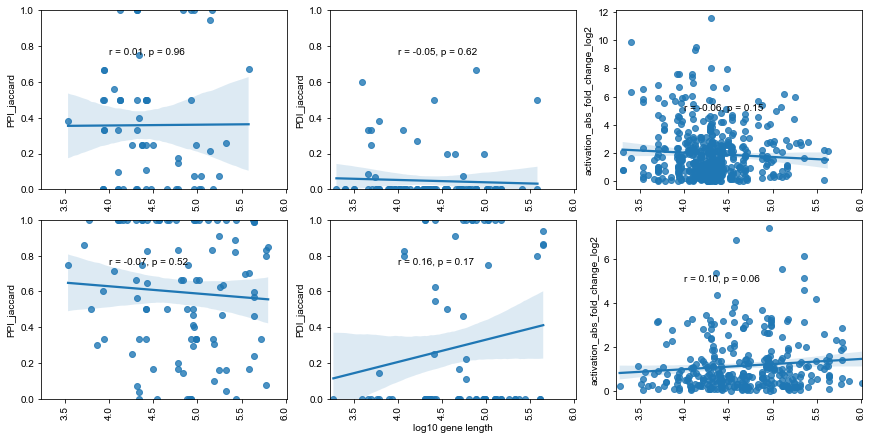

In [80]:
# TODO: log transform
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=6)
for cat, ax_row in zip(['paralogs', 'isoforms'], axs):
    for var, ax in zip(['PPI_jaccard', 'PDI_jaccard', 'activation_abs_fold_change_log2'], ax_row):
        data = df.loc[
                    (df['category'] == cat), :]
        sns.regplot(data=data,
                    x='gene_length_min_log10',
                    y=var,
                    #ci=68,
                    ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_xlabel('')
        ax.set_xlim(df['gene_length_min_log10'].min(), df['gene_length_min_log10'].max())
        r, p = stats.pearsonr(data.loc[data['gene_length_min_log10'].notnull() & data[var].notnull(), 'gene_length_min_log10'].values,
                              data.loc[data['gene_length_min_log10'].notnull() & data[var].notnull(), var].values)
        ax.text(s='r = {:.2f}, p = {:.2f}'.format(r, p),
                x=4, y=5 if var == 'activation_abs_fold_change_log2' else 0.75)
#axs[0].set_ylabel('Activation fold change')
axs[1, 1].set_xlabel('log10 gene length')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
fig.savefig('../figures/paralogs_by-gene-length_assaydiffs.pdf',
            bbox_inches='tight')

In [84]:
genes = pd.DataFrame(data=[(name, len(tf.isoforms), fam_size[name], gene_length[name], age[name] if name in age else np.nan) for name, tf in tfs.items()],
                     columns=['name', 'n_isoforms', 'family_size', 'gene_length', 'age'])
genes.head()

,name,n_isoforms,family_size,gene_length,age
0,ZBTB18,2,747.0,8538,Eumetazoa
1,PRRX1,3,196.0,76694,Eumetazoa
2,POU2F1,4,16.0,206470,Eumetazoa
3,ATF3,4,54.0,55444,Eumetazoa
4,GRHL3,6,6.0,45161,Opisthokonta


<AxesSubplot: xlabel='family_size', ylabel='n_isoforms'>

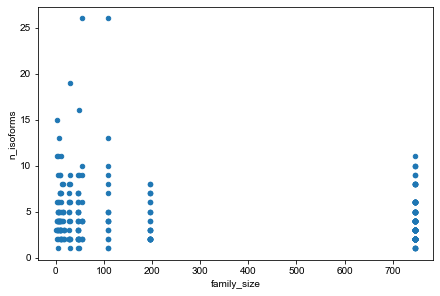

In [85]:
x = 'family_size'
y = 'n_isoforms'
fig, ax = plt.subplots(1, 1)
genes.plot.scatter(x=x, y=y, ax=ax)

In [49]:
compara = pd.read_csv('../data/external/Ensembl_TF_paralogs.txt',
                      sep='\t')
compara = compara.dropna()
compara.head()

,Gene stable ID,Gene name,Human paralogue gene stable ID,Human paralogue associated gene name,Paralogue last common ancestor with Human,Human paralogue homology type,Paralogue %id. target Human gene identical to query gene
1,ENSG00000005102,MEOX1,ENSG00000106511,MEOX2,Vertebrata,within_species_paralog,48.0315
2,ENSG00000006194,ZNF263,ENSG00000197279,ZNF165,Vertebrata,other_paralog,27.6720
3,ENSG00000006194,ZNF263,ENSG00000137338,PGBD1,Vertebrata,other_paralog,17.1303
4,ENSG00000006194,ZNF263,ENSG00000122386,ZNF205,Vertebrata,other_paralog,18.8873
5,ENSG00000006194,ZNF263,ENSG00000189298,ZKSCAN3,Vertebrata,other_paralog,31.9180


In [50]:
compara['gene_pair'] = (compara[['Gene name', 'Human paralogue associated gene name']].min(axis=1)
                        + '_' +
                        compara[['Gene name', 'Human paralogue associated gene name']].max(axis=1))
df['gene_pair'] = df['gene_symbol_a'] + '_' + df['gene_symbol_b']

<ipython-input-50-e6cb54e923e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gene_pair'] = df['gene_symbol_a'] + '_' + df['gene_symbol_b']


In [53]:
compara.loc[compara['gene_pair'].duplicated(keep=False)].sort_values('gene_pair')

,Gene stable ID,Gene name,Human paralogue gene stable ID,Human paralogue associated gene name,Paralogue last common ancestor with Human,Human paralogue homology type,Paralogue %id. target Human gene identical to query gene,gene_pair
1610,ENSG00000111087,GLI1,ENSG00000139154,AEBP2,Bilateria,other_paralog,7.9566,AEBP2_GLI1
2807,ENSG00000139154,AEBP2,ENSG00000111087,GLI1,Bilateria,other_paralog,17.4950,AEBP2_GLI1
2815,ENSG00000139154,AEBP2,ENSG00000126603,GLIS2,Bilateria,other_paralog,13.5189,AEBP2_GLIS2
2266,ENSG00000126603,GLIS2,ENSG00000139154,AEBP2,Bilateria,other_paralog,12.9771,AEBP2_GLIS2
2814,ENSG00000139154,AEBP2,ENSG00000152977,ZIC1,Bilateria,other_paralog,13.9165,AEBP2_ZIC1
...,...,...,...,...,...,...,...,...
7598,ENSG00000197037,ZSCAN25,ENSG00000197062,ZSCAN26,Vertebrata,other_paralog,26.6544,ZSCAN25_ZSCAN26
7580,ENSG00000197037,ZSCAN25,ENSG00000137185,ZSCAN9,Vertebrata,other_paralog,25.0000,ZSCAN25_ZSCAN9
2714,ENSG00000137185,ZSCAN9,ENSG00000197037,ZSCAN25,Vertebrata,other_paralog,34.5178,ZSCAN25_ZSCAN9
2733,ENSG00000137185,ZSCAN9,ENSG00000197062,ZSCAN26,Vertebrata,other_paralog,40.1015,ZSCAN26_ZSCAN9


In [54]:
df['compara_pct_id'] = df['gene_pair'].map(
    compara.drop_duplicates('gene_pair').set_index('gene_pair')['Paralogue %id. target Human gene identical to query gene'])

<ipython-input-54-6ef8049f6ee9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compara_pct_id'] = df['gene_pair'].map(


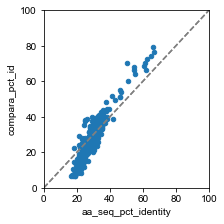

In [58]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(3, 3)
ax.plot([0, 100], [0, 100], linestyle='--', color='grey')
df.loc[df['category'] == 'paralogs',
       :].plot.scatter(x='aa_seq_pct_identity',
                       y='compara_pct_id',
                       ax=ax)
ax.set_ylim(0, 100)
ax.set_xlim(0, 100)
ax.plot([0, 100], [0, 100], linestyle='--', color='grey')